In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import folium
#from github import Github

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [113]:
dfx = pd.read_csv(os.getcwd()+'\\Praha_Apartment_Scraped_Data\\aaa.csv')

In [114]:
# df = pd.read_csv(os.getcwd()+'\\Praha_Apartment_Scraped_Data\\Prague-Bezrealitky-2021-12-31.csv')

In [115]:
def missing_data(df):
    return 100*df.isnull().sum()/len(df)

In [116]:
def droping_data(df):
    
    df = df.drop('Listing ID',axis=1) 
    df = df.drop('New building',axis=1)
    df = df.drop('Front garden',axis=1)
    df = df.drop('Developer name',axis=1)
    df = df.drop('Project name',axis=1)
    df = df.drop('Kód jednotky',axis=1)
    df = df.drop('Administration fee',axis=1)
    df = df.drop('Ownership Type',axis=1)
    df = df.drop('Refundable security deposit',axis=1)
    df = df.drop('Available from',axis=1)
    df = df.drop('Playground',axis=1)
    df = df.drop('Post office',axis=1)
    df = df.drop('Bank',axis=1)
    df = df.drop('Pharmacy',axis=1)
    df = df.dropna(axis=0,subset=['Floor Space'])
    
    return df

In [117]:
def district_extract(string):
    return string.split('Prague - ')[1]

In [118]:
def rare_district_renaming(district):
    if district not in df['District'].value_counts()[:25].index:
        return 'Other'
    else:
        return district

In [119]:
def feature_engineering(df):
    
    df['Price'] = pd.to_numeric(df['Price'].str.replace('CZK ','').str.replace(',',''))
    df['Fees'] = pd.to_numeric(df['Fees'].str.replace('CZK ','').str.replace(',',''))
    df['Floor Space'] = pd.to_numeric(df['Floor Space'].str.replace(' m²',''))
    df['District'] = df['District'].apply(district_extract)
    df['District'] = df['District'].apply(rare_district_renaming)
    
    if df['Public transport stop'].dtype == 'O':
        df['Public transport stop'] = pd.to_numeric(df['Public transport stop'].str.replace(',',''))
    if df['Shop'].dtype == 'O':
        df['Shop'] = pd.to_numeric(df['Shop'].str.replace(',',''))
    if df['Restaurant'].dtype == 'O':
        df['Restaurant'] = pd.to_numeric(df['Restaurant'].str.replace(',',''))
    if df['School'].dtype == 'O':
        df['School'] = pd.to_numeric(df['School'].str.replace(',',''))
    if df['Kindergarten'].dtype == 'O':
        df['Kindergarten'] = pd.to_numeric(df['Kindergarten'].str.replace(',',''))
    if df['Sports field'].dtype == 'O':
        df['Sports field'] = pd.to_numeric(df['Sports field'].str.replace(',',''))
    
    return df

In [120]:
def filtering_outliers(df):
    
    df = df[df['Floor Space']>10]
    df = df[df['Floor Space']<125]
    df = df[df['Price']>3000]
    df = df[df['Price']<30000]
    df = df[df['Fees']<10000]
    df.loc[df['Fees']<400,'Fees'] = np.nan
    
    return df

In [121]:
def fixing_fees(df):
    
    df['ratio'] = df['Price']/df['Fees']
    df.loc[(df['ratio'].between(2.95,3.05)) & (df['Price']>10000),'Fees'] = np.nan
    df = df.drop('ratio',axis=1)
    fees_df = df[['Floor Space','Fees']]
    fees_df = fees_df.dropna()
    fees_coeff = np.polyfit(fees_df['Floor Space'],fees_df['Fees'],1)
    df['Fees'] = df['Fees'].fillna(fees_coeff[0]*df['Floor Space'] + fees_coeff[1])
    
    return df

In [122]:
def total_cost(df):
    
    df['Total price'] = df['Price']+df['Fees']
    df = df.drop('Price',axis=1) 
    df = df.drop('Fees',axis=1) 
    
    return df

In [123]:
def mapping_data(df):
    
    df['Layout'] = df['Layout'].map({
                                        'Small studio':0.5, 
                                        'Studio':0.75,
                                        '1 bedroom with open-plan kitchen':1.5,
                                        '1 bedroom':1,
                                        '2 bedroom with open-plan kitchen':2.5,
                                        '2 bedroom':2,
                                        '3 bedroom with open-plan kitchen':3.5,
                                        '3 bedroom':3,
                                        '4 bedroom with open-plan kitchen':4.5,
                                        '4 bedroom':4,
                                        '5 bedroom with open-plan kitchen':5.5,   
                                        '5 bedroom':5,
                                        '6 bedroom':6.5,
                                                                                })
    
    
    df['PENB'] = df['PENB'].map({'G':7,'F':6,'E':5,'D':4,'C':3,'B':2,'A':1})
    
    df['Balcony'] = df['Balcony'].map({'Yes':1,'No':0})
    df['Terrace'] = df['Terrace'].map({'Yes':1,'No':0})
    df['Cellar'] = df['Cellar'].map({'Yes':1,'No':0})
    df['Loggia'] = df['Loggia'].map({'Yes':1,'No':0})
    df['Parking'] = df['Parking'].map({'Yes':1,'No':0})
    df['Lift'] = df['Lift'].map({'Yes':1,'No':0})
    df['Garage'] = df['Garage'].map({'Yes':1,'No':0})
    
    return df

In [124]:
def replacing_categories(df):
    
    df['Condition'] = df['Condition'].replace('In need of repair',np.nan)
    df['Building Type'] = df['Building Type'].replace('Wooden building',np.nan)
    df['Total number of floors'] = df['Total number of floors'].replace('Raised ground floor','Ground floor')
    df['Heating'] = df['Heating'].replace('Geothermal heat pump',np.nan)
    df.loc[df['Floor']>10,'Floor'] = 10
    df['Age'] = df['Age'].replace('over 50 years years','over 30 years years')
    df['Age'] = df['Age'].replace('30 to 50 years years','over 30 years years')
    df['Renovation'] = df['Renovation'].replace('Exterior',np.nan)
    df['Renovation'] = df['Renovation'].replace('Bathroom unit',np.nan)
    
    return df

In [125]:
def missing_values(df):
    
#     df['Condition'] = df['Condition'].fillna('Missing')
#     df['Building Type'] = df['Building Type'].fillna('Missing')    
#     df['Furnishing and Fittings'] = df['Furnishing and Fittings'].fillna('Missing')    
    df['Design'] = df['Design'].fillna('Standard materials and solutions')
#     df['Total number of floors'] = df['Total number of floors'].fillna('Missing')
#     df['Heating'] = df['Heating'].fillna('Missing')
    df['Floor'] = df['Floor'].fillna(1)
#     df['Age'] = df['Age'].fillna('Missing')
#     df['Renovation'] = df['Renovation'].fillna('Missing')
    df['Public transport stop'] = df['Public transport stop'].fillna(df['Public transport stop'].median())
    df['Shop'] = df['Shop'].fillna(df['Shop'].median())
    df['Restaurant'] = df['Restaurant'].fillna(df['Restaurant'].median())
    df['School'] = df['School'].fillna(df['School'].median())
    df['Kindergarten'] = df['Kindergarten'].fillna(df['Kindergarten'].median())
    df['Sports field'] = df['Sports field'].fillna(df['Sports field'].median())
    df['PENB'] = df['PENB'].fillna(np.round(df.groupby('Building Type')['PENB'].transform('mean'),0))
    df['PENB'] = df['PENB'].fillna(5)
    
    
    return df

In [126]:
dfx = droping_data(dfx)
dfx = feature_engineering(dfx)
dfx = filtering_outliers(dfx)
dfx = fixing_fees(dfx)
dfx = total_cost(dfx)
dfx = mapping_data(dfx)
dfx = replacing_categories(dfx)
dfx = missing_values(dfx)

In [127]:
y = dfx['Total price']
X = dfx.drop('Total price',axis=1)

In [128]:
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')

In [180]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=101,shuffle=True)

## Sklearn's Granding Boosting Regressor

In [42]:
grid_paramters = {'n_estimators': [100,250,500],
                  'learning_rate':[0.02,0.04,0.06,0.08,0.10],
                  'subsample':[0.2,0.4,0.6,0.8,1.0],
                  'min_samples_split':[2,3,4,5],
                  'min_samples_leaf':[1,2,3,4,5],
                  'max_depth':[1,2,3,4,5,6],        
                  'max_features': ['auto','sqrt']}

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR_grid = RandomizedSearchCV(estimator = GBR,
                              scoring = 'neg_mean_absolute_error',
                              param_distributions = grid_paramters,
                              n_iter = 300,
                              cv = 5,
                              verbose=2,
                              random_state=101,
                              n_jobs = -1)
GBR_grid.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.02, 0.04, 0.06,
                                                          0.08, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 250, 500],
                                        'subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
                   random_state=101, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
GBR_grid.fit(X_train,y_train)

In [62]:
from sklearn.metrics import mean_absolute_error

y_pred_train = GBR_grid.predict(X_train)
y_pred = GBR_grid.predict(X_test)

MAE = mean_absolute_error(y_test,y_pred)
ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
print(f'Mean error test: {np.round(MAE)} CZK')
print(f'Mean error test: {np.round(ERR)} %\n')

MAE2 = mean_absolute_error(y_train,y_pred_train)
ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)
print(f'Mean error train: {np.round(MAE2)} CZK')
print(f'Mean error train: {np.round(ERR2)} %')

Mean error test: 1957.0 CZK
Mean error test: 11.0 %

Mean error train: 760.0 CZK
Mean error train: 4.0 %


## XGBoost

In [138]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

In [185]:
grid_paramters = {
                   'n_estimators': randint(10,250),
                   'eta': uniform(0.001,0.3),
                   'gamma': uniform(0.01,5),
                   'max_depth':[1,2,3,4,5,6],
                   'subsample': uniform(0.01,0.99),
                   'colsample_bytree': uniform(0.01,0.99),
                   'colsample_bylevel': uniform(0.01,0.99),
                   'min_child_weight': uniform(0.1,10),
                   'reg_lambda': uniform(0,100),
                   'reg_alpha': uniform(1,500)
                 }

In [186]:
# grid_paramters = {
#                    'n_estimators': [200],
#                    'eta':[0.01,0.05,0.1,0.15],
#                    'gamma':[0.1,0.5,1],
#                    'max_depth':[1,2,3,4,5],
#                    'subsample':[0.5,0.75,1],
#                    'colsample_bytree':[0.25,0.5,0.75],
#                    'reg_lambda':[0,0.25,0.5],
#                    'reg_alpha':[25,75,150,200,300],
#                    'eval_metric':['mae']
#                  }

In [193]:
xgb1 = xgb.XGBRegressor()
xgb_grid = RandomizedSearchCV(
                                estimator = xgb1,
                                param_distributions = grid_paramters,
                                scoring = 'neg_mean_absolute_error',
                                n_iter = 5000,
                                cv = 6,
                                verbose=0,
                                random_state=101,
                                n_jobs = -1
                              )

xgb_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=6,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027D48122B50>,
                                        'reg_alpha': <scipy

In [194]:
from sklearn.metrics import mean_absolute_error

y_pred_train = xgb_grid.predict(X_train)
y_pred = xgb_grid.predict(X_test)

MAE = mean_absolute_error(y_test,y_pred)
ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
print(f'Mean error test: {np.round(MAE)} CZK')
print(f'Mean error test: {np.round(ERR)} %\n')

MAE2 = mean_absolute_error(y_train,y_pred_train)
ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)
print(f'Mean error train: {np.round(MAE2)} CZK')
print(f'Mean error train: {np.round(ERR2)} %')

Mean error test: 1983.0 CZK
Mean error test: 11.0 %

Mean error train: 1359.0 CZK
Mean error train: 8.0 %


In [195]:
xgb_best_parameters = xgb_grid.best_params_

In [196]:
xgb_best_parameters

{'colsample_bylevel': 0.3379726803401046,
 'colsample_bytree': 0.6002960743414038,
 'eta': 0.05377796049525406,
 'gamma': 3.3904296813165344,
 'max_depth': 6,
 'min_child_weight': 5.547754647537617,
 'n_estimators': 223,
 'reg_alpha': 88.33186638511059,
 'reg_lambda': 32.744573256137876,
 'subsample': 0.6898900130675434}

In [197]:
xgb2 = xgb.XGBRegressor(
                        subsample = 0.7,
                        reg_lambda = 32,
                        reg_alpha = 88,
                        n_estimators = 200,
                        max_depth =  6,
                        gamma = 3,
                        eval_metric = 'mae',
                        eta = 0.05,
                        colsample_bytree = 0.6,
                        colsample_bylevel = 0.3
                        )

In [198]:
xgb2.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             eta=0.05, eval_metric='mae', gamma=3, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=88, reg_lambda=32, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [199]:
from sklearn.model_selection import cross_val_score

print('Cross validation score:')
print(np.mean(-cross_val_score(xgb2,X,y,cv=10,scoring='neg_mean_absolute_error')))

Cross validation score:
2072.655870728714


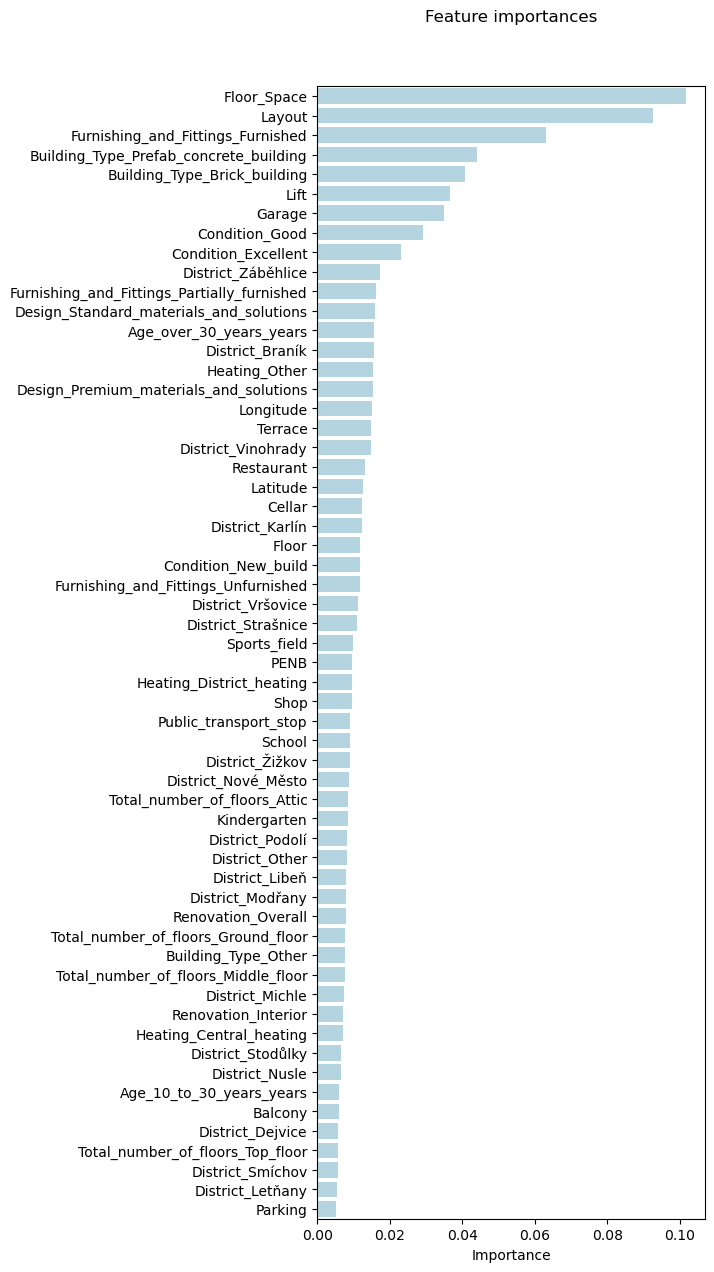

In [200]:
feat_import = xgb2.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats = imp_feats[imp_feats['Importance'] > 0.005]
imp_feats = imp_feats.sort_values("Importance",ascending=False)
plt.figure(figsize=(5,15),dpi=100)
sns.barplot(data=imp_feats,y=imp_feats.index,x='Importance',color='lightblue');
plt.title('Feature importances',y=1.05);
# plt.xticks(rotation=80);